In [25]:
import sys
sys.path.insert(1, 'C:/Users/uhv.stm/Documents/Corinna/V1.8')
import matplotlib.pyplot as plt
import numpy as np
from simscidapy import Curve
from simscidapy import Map
from Physics import BCS, apply_lock_in_broadening
from Superconducting_Sample import NIS,SIN_Spectrum
from Sionludi_Measurement import *
from Nanonis_Measurement import *
from datetime import datetime
import matplotlib.colors as colors	
import matplotlib.cm as cmx
from IPython.display import display

from ipywidgets import *

In [26]:
path_rawdata="C:/Users/uhv.stm/Documents/Corinna/Ga/Ga_analysis/raw data/"
current_sample = "Ga"
current_area = 1

# general data
current_T = 0.06 #cryo temperature
current_Isp = 0.5e-6 #current setpoint
current_Vb = 0.8e-3 #bias setpoint
current_Vac=25e-3*1e-3 #ac voltage applied to lockin

#load data
#Plot will be saved in the same folder, corresponding to given path
folder="2022-04-30"
filename_raw="22-04-30_BiasSpectroscopy001"

file=filename_raw+".dat"
filename=path_rawdata+ "/" +folder+"/"+ file

#load bias spectro or grid spectro
BS = Nan_BiasSpectroscopy(
        title       = filename_raw,
        filename    = filename,
        sample      = current_sample,
        T           = current_T,
        area        = current_area
    ).load()

BS.correct_bias_offset()

#define Spectrum
spectrum = BS.get_dIdV(lock_in_signal='Input 3 (V)',scan_dir='avg').apply_transformation(lambda x,y: (x*1000,y))
spectrum = (1/NIS.get_normal_state_conductance(spectrum))*spectrum

<IPython.core.display.Javascript object>


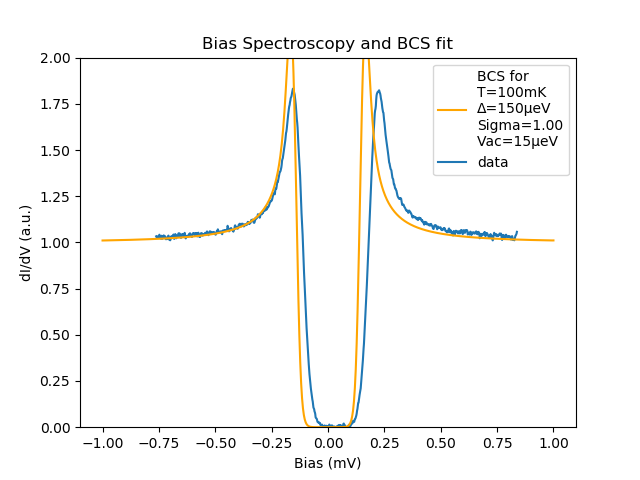

Button(description='Savefig', style=ButtonStyle())

interactive(children=(FloatSlider(value=100.0, description='T (mK)', layout=Layout(width='800px'), max=1200.0,…

In [28]:
%matplotlib notebook
x_range = (-1e-3,1e-3) # in V
y_range = (0,2) 

fig,ax = plt.subplots()

button = Button(description="Savefig")
display(button)

### Plot spectrum in the background
xb, yb = spectrum.get_x_y()
line_bgnd, = ax.plot(xb,yb,label='data')

### Plot the theory on top

T = 0.1
Delta=150e-6
x = np.linspace(x_range[0],x_range[1],1000)
Sigma = 1
Vac = 15e-6
theory = SIN_Spectrum.real_dIdV(
    x = x,
    sig0 = Sigma,
    Delta = Delta,
    T=T,
    V_ac_rms=Vac
)
label=f'BCS for \nT={T*1000}mK\nΔ={Delta*1e6}µeV\nSigma={Sigma}\nVac={Vac*1e6}µeV'
line, = ax.plot(x*1000,theory,label=label,color='orange')

ax.set_title(f'Bias Spectroscopy and BCS fit')
ax.set_xlabel('Bias (mV)')
ax.set_ylabel('dI/dV (a.u.)')
legend = ax.legend(bbox_to_anchor=(1.1, 1.05))#loc='lower right')
ax.set_ylim(*y_range)

def update(T=T,Sigma=Sigma,Delta=Delta,Vac=Vac,offset=0):
    line.set_ydata(SIN_Spectrum.real_dIdV(
    x = x,
    sig0 = Sigma,
    Delta = Delta*1e-6,
    T=T*1e-3,
    V_ac_rms=Vac*1e-6))
    ax.legend([line,line_bgnd],[f'BCS for \nT={T:.0f}mK\nΔ={Delta:.0f}µeV\nSigma={Sigma:.2f}\nVac={Vac:.0f}µeV','data'])
    #label=f'BCS for \nT={T*1000}mK\nΔ={Delta*1e6}µeV\nSigma={Sigma}-\nVac={Vac*1e6}µeV'
    #ax.legend(bbox_to_anchor=(1.1, 1.05))
    line_bgnd.set_xdata(xb-offset)
    fig.canvas.draw_idle() #fig.canvas.draw()#
    
def on_button_clicked(b):
    title=path_rawdata+ "/" +folder+"/"+ filename_raw+".png"
    fig.savefig(title, dpi='figure', format="png")
button.on_click(on_button_clicked)

interact(update,
        T=widgets.FloatSlider(value=100, min=50, max=1200, step=1, readout_format='.0f',layout=Layout(width='800px'),description='T (mK)'),
        Sigma=widgets.FloatSlider(min=0.9, max=1.5, step=1e-3, value=1,readout_format='.2f',layout=Layout(width='800px')),
        Delta=widgets.FloatSlider(min=0, max=200, step=1, value=Delta*1e6,readout_format='.0f',layout=Layout(width='800px'),description='Delta (ueV)'),
        Vac=widgets.FloatSlider(min=1, max=30, step=1, value=Vac*1e6,readout_format='.0f',layout=Layout(width='800px'),description='Vac rms (uV)'),
        offset=widgets.FloatSlider(min=-0.1, max=0.1, step=1e-3, value=0,readout_format='.3f',layout=Layout(width='800px'),description='offset (mV)'),
        b=button);